# Банки — Анализ оттока клиентов

**Задача:** Проанализируйте клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка, предложите рекомендации по удержанию этих клиентов.

Заказчик — менеджер из отдела маркетинга банка «Метанпромбанк», он будет смотреть только итоговую презентацию.

Заказчик хочет максимально эффективно выделить сегменты отточных клиентов, чтобы они были однородными, высокоточными и покрывали максимум проблемных зон банка, чтобы маркетинговые решения для этих сегментов могли уменьшить отток клиентов.


План работы:

1. Загрузка данных и изучение общей информации
2. Предобработка данных
3. Исследовательский анализ данных
4. Проверка статистических гипотез
5. Формулирование промежуточного итога о том, какие показатели статистически влияют на отток
6. Сегментация на основе стратегических показателей
7. Выводы и рекомендации для заказчика

Презентация для заказчика: <https://disk.yandex.ru/i/puplC3gMt6AU_A> 

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
!pip install phik  --quiet
import phik
from phik.report import plot_correlation_matrix
from phik import report
from scipy.stats import shapiro
from scipy import stats as st
from itertools import combinations
import re
from pandas import option_context

In [2]:
data = pd.read_csv('/datasets/bank_scrooge.csv')
data.info()   
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


**Заключение по шагу 1:** Перед проведением анализа данные требуют предобработки - переименования столбцов, проверки наличия пропусков и дубликатов, кодирования данных для анализа

## Предобработка данных
### Переименование столбцов

In [3]:
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})
#data.info()

### обработка пропусков

In [4]:
data.isna().sum().to_frame().style.background_gradient()

,0
user_id,0
score,0
city,0
gender,0
age,26
equity,0
balance,2295
products,0
credit_card,0
last_activity,0


Много пропусков в колонке balance, изучим их далее

удалим пропуска в колонке age, их менее 1% данных

In [5]:
data = data.dropna(subset = ['age']).reset_index(drop=True)
data.isna().sum().to_frame().style.background_gradient()

,0
user_id,0
score,0
city,0
gender,0
age,0
equity,0
balance,2279
products,0
credit_card,0
last_activity,0


Попробуем найти причину появления пропусков и отнести их к категории случайных или неслучайных. Для этого определим долю пропусков среди отточных и неотточных клиентов, по городамб в зависимости от активности,  наличия кредитной карты, количества баллов собственности и количества продуктов, которыми пользуется клиент

##### Функция missing_balance

In [6]:
''' функция missing_balance рассчитывает долю пропусков в balance для каждого значения выбранного столбца и количество
клиентов с этим значением 
на вход принимается название интересующего столбца'''

def missing_balance (column):
    for value in data[column].unique():
        print ('Доля пропусков в balance при значении', value, 'столбца', column, 'составляет:', 
               round(data.loc[data[column] == value, 'balance'].isna().sum()/len(data.loc[data[column] == value])*100, 2), '%',
              'из количества клиентов', len(data.loc[data[column] == value]))
    return

In [7]:
missing_balance('churn')

Доля пропусков в balance при значении 1 столбца churn составляет: 0.71 % из количества клиентов 1819
Доля пропусков в balance при значении 0 столбца churn составляет: 27.79 % из количества клиентов 8155


In [8]:
missing_balance('city')

Доля пропусков в balance при значении Рыбинск столбца city составляет: 21.84 % из количества клиентов 2683
Доля пропусков в balance при значении Ярославль столбца city составляет: 24.82 % из количества клиентов 5875
Доля пропусков в balance при значении Ростов столбца city составляет: 16.6 % из количества клиентов 1416


In [9]:
missing_balance('last_activity')

Доля пропусков в balance при значении 1 столбца last_activity составляет: 23.99 % из количества клиентов 5215
Доля пропусков в balance при значении 0 столбца last_activity составляет: 21.6 % из количества клиентов 4759


In [10]:
missing_balance('credit_card')

Доля пропусков в balance при значении 0 столбца credit_card составляет: 13.2 % из количества клиентов 3190
Доля пропусков в balance при значении 1 столбца credit_card составляет: 27.39 % из количества клиентов 6784


In [11]:
missing_balance('equity')

Доля пропусков в balance при значении 1 столбца equity составляет: 14.75 % из количества клиентов 773
Доля пропусков в balance при значении 5 столбца equity составляет: 0.0 % из количества клиентов 1915
Доля пропусков в balance при значении 0 столбца equity составляет: 84.01 % из количества клиентов 2576
Доля пропусков в balance при значении 4 столбца equity составляет: 0.0 % из количества клиентов 1847
Доля пропусков в balance при значении 3 столбца equity составляет: 0.06 % из количества клиентов 1541
Доля пропусков в balance при значении 2 столбца equity составляет: 0.0 % из количества клиентов 1051
Доля пропусков в balance при значении 6 столбца equity составляет: 0.0 % из количества клиентов 161
Доля пропусков в balance при значении 7 столбца equity составляет: 0.0 % из количества клиентов 80
Доля пропусков в balance при значении 8 столбца equity составляет: 0.0 % из количества клиентов 17
Доля пропусков в balance при значении 9 столбца equity составляет: 0.0 % из количества клиен

In [12]:
missing_balance('products')

Доля пропусков в balance при значении 2 столбца products составляет: 6.15 % из количества клиентов 5119
Доля пропусков в balance при значении 3 столбца products составляет: 2.79 % из количества клиентов 1038
Доля пропусков в balance при значении 1 столбца products составляет: 58.2 % из количества клиентов 3323
Доля пропусков в balance при значении 4 столбца products составляет: 0.0 % из количества клиентов 474
Доля пропусков в balance при значении 5 столбца products составляет: 0.0 % из количества клиентов 19
Доля пропусков в balance при значении 0 столбца products составляет: 100.0 % из количества клиентов 1


наибольшая доля пропусков в balance у клиентов, имеющих количество баллов собственности 0 (84% пропусков) и/или использующих только один продукт (58,2% пропусков). Большинство этих клиентов не собираются уходить из банка. В 2 раза выше доля пропусков в у клиентов с кредитной картой. Зависимости между пропусками в balance и городом проживания, последней активностью не выявлено.
У клиентов, не использующих ни одного продукта банка, 100% пропусков, но это только один человек (странно, что клиент не пользуется ни одним подуктом, удалю эту строку)

Значит пропуски не случайные, MNAR (Missing Not At Random), не буду их заполнять. Добавлю столбец missing_balance для дальнейшего изучения пропусков, где 0 - нет пропуска, 1 - есть пропуск

Предположу причины пропусков: новые клиенты, информация по которым еще не подгрузилась, отрицательный баланс из-за использования кредитных средств или назавершенное обновление информации в базе

In [13]:
data = data[data['products']!=0].reset_index(drop=True)
#data.info()

добавлю колонку с информацией о наличии или отсутствии данных о балансе

In [14]:
data['missing_balance'] = 0
for i in range(len(data)):
    if pd.isnull(data.loc[i, 'balance']):
        data.loc[i, 'missing_balance'] = 1
#data.head(20)

### Кодирование при помощи фиктивных переменных

перед кодированием продублирую столбцы. чтобы их не потерять

In [15]:
data['gender1'] = data.loc[:, 'gender']
data = pd.get_dummies(data, columns=['gender1'])
#data.info()

In [16]:
data['city1'] = data.loc[:, 'city']
data = pd.get_dummies(data, columns=['city1'])
#data.info()

Переименуем новые столбцы, чтобы не было названий на кириллице

In [17]:
data = data.rename(columns={'gender1_Ж': 'female', 'gender1_М': 'male', 'city1_Ростов': 'rostov', 
                            'city1_Рыбинск': 'rybinsk', 'city1_Ярославль': 'yaroslavl'})
#data.info()

### Анализ дубликатов

In [18]:
data.duplicated().sum()

0

полных дубликатов нет, проверим дубликаты по id, тк они должны быть уникальными

In [19]:
data['user_id'].duplicated().sum()

50

50 дубликатов по id, посмотрим на них. Предположу, что, если это одни и те же люди, у них должен совпадать как минимум  пол, возможно еще город

In [20]:
data[data.duplicated(['user_id'], keep = False)].sort_values(by = 'user_id').head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,female,male,rostov,rybinsk,yaroslavl
1892,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,1,0,0,1,0
7683,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,1,1,0,0,0,1
4862,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,1,0,0,1,0
7531,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,1,1,0,0,0,1
5856,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,1,0,0,1,0


In [21]:
data[data.duplicated(['user_id'], keep = False)].groupby('city')['user_id'].nunique()

city
Рыбинск      50
Ярославль    50
Name: user_id, dtype: int64

под дубликатами по id находятся разные люди (отличаются все столбцы, кроме id), причем каждому дубликату соответствует пара городов Рыбинск и Ярославль, видимо, была ошибка связи между базами данных этих городов

Удалять или изменять эти дубликаты не буду, дублирование по id не критично для анализа. (Или можно было бы изменить id, например добавив 1000000 к значению)

**Заключение по шагу 2:** выполнена предобработка данных. Переименованы столбцы, удалены строки с пропущенным возрастом, изучена природа пропусков в колонке balance, принято решение об их оставлении и добавлен столбец missing balance для дальшенейшего изучения, столбцы gender и city закодированы с помощью фиктивных переменных, изучены дубликаты, и принято решение об их оставлении.

## Шаг 3. Исследовательский анализ данных

построю общую гистограмму для всех числовых столбцов таблицы

К категориальным признакам в наших данных относятся city , gender, equity, Products, credit_card, last_activity, churn, missing_balance

к количественным - дискретные age и score, и непрерывные Balance, est_salary


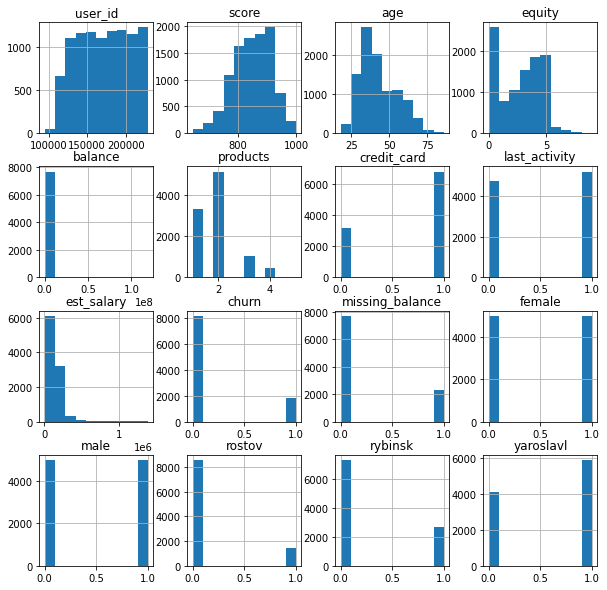

In [22]:
data.hist(figsize=(10, 10));


### Анализ распределения количественных признаков и их категоризация в разрезе оттока
Изучим распределения количественных характеристик в разрезе оттока, построим гистограммы или kde-графики. Выделим категории признаков для дальшейшего анализа.

#### Количественный портрет отточного и не отточного клиента

In [23]:
portrait_by_churn = data.groupby(['churn'], as_index=False).mean()
portrait_by_churn_t = portrait_by_churn.T
portrait_by_churn_t = portrait_by_churn_t.rename(columns={1: 'churn', 0: 'non_churn'})
portrait_by_churn_t.drop(labels = ['churn'],axis = 0, inplace = True)
portrait_by_churn_t['churn/non_churn, %'] = round(portrait_by_churn_t['churn']/portrait_by_churn_t['non_churn']*100-100, 2)
portrait_by_churn_t = portrait_by_churn_t.sort_values(by = 'churn/non_churn, %', ascending =  False)
display(portrait_by_churn_t)

,non_churn,churn,"churn/non_churn, %"
equity,2.378296,3.763476e+00,58.24
balance,733031.630149,1.134458e+06,54.76
last_activity,0.482894,7.024202e-01,45.46
male,0.466953,6.507151e-01,39.35
products,1.758921,2.377338e+00,35.16
yaroslavl,0.583446,6.144114e-01,5.31
rostov,0.141140,1.457646e-01,3.28
score,845.396199,8.633619e+02,2.13
est_salary,147674.637881,1.483575e+05,0.46
user_id,171928.110607,1.709928e+05,-0.54


Наибольшая разница между группами отточных и неотточных клиентов **в пользу отточных** выявлена в: количестве баллов собственности - разница между отточными и неотточными клиентами составляет 58,24%, балансе - разница между отточными и неотточными клиентами составляет 54,76%, активности - разница между отточными и неотточными клиентами составляет 45,46%, поле - мужской пол встречается чаще на 39,35%, количестве испоьзуемых продуктов - на 35,16%. 

Разница менее 10% между группами в характеристиках: город проживания Ростов и Ярославль, баллы кредитного рейтинга, зарплата и возраст. 

Наибольшая разница между группами отточных и неотточных клиентов **в пользу неотточных** выявлена в: город Рыбинск - разница между отточными и неотточными клиентами составляет -12,92%, наличие кредитной карты - разница -22,17%, женский пол - разница -34,47%, отсутствие данных о балансе на счете - 97,62%.

#### Связь оттока и кредитного рейтинга
##### Функция histplot_churn для гистограммы оттока

In [24]:
''' функция histplot_churn создает гистограмму, показывающую плотность вероятности ухода клиентов в зависимости 
от заданной характеристики 
на вход принимаются название интересующего столбца, название таблицы, подпись для оси х'''

def histplot_churn (column, title, xlabel):
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.histplot(data = data, x =column, hue = 'churn', stat="density", common_norm=False, ax=ax, bins = 70).\
                set(title=title);
    plt.legend(labels=["Остаются","Уходят"])
    plt.xlabel(xlabel)
    plt.ylabel('Плотность вероятности')

    plt.show ()
    return

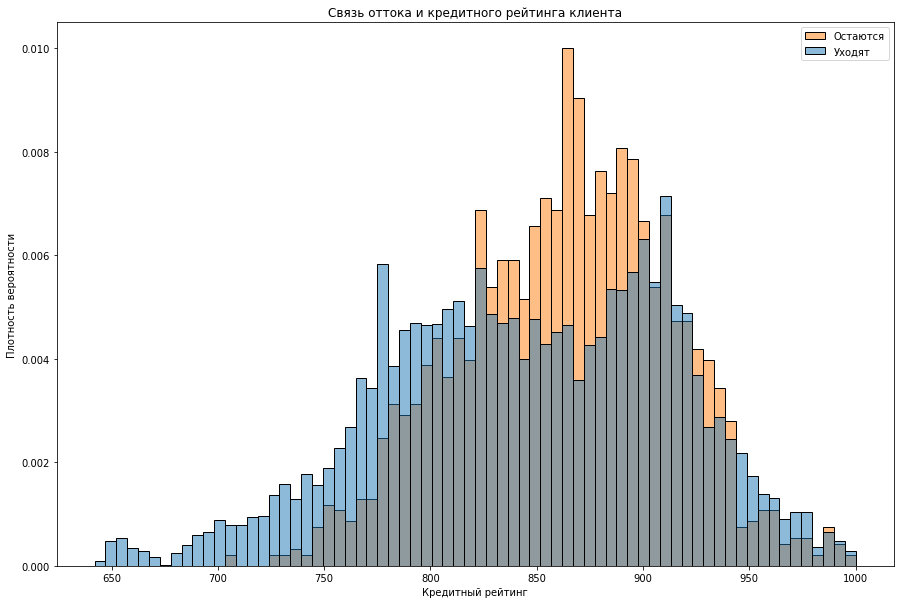

In [25]:
histplot_churn ('score', 'Связь оттока и кредитного рейтинга клиента', 'Кредитный рейтинг')

Доли уходящих клинетов выше, чем доли остающихся, среди клиентов с кредитным рейтингом до 820 и выше 940. На основании этих результатов можно выделить 3 группы клиентов с распределением по рейтингу. Создадим группы 1 - рейтинг менее 820, 2 - рейтинг от 820 до 940, 3 - рейтинг более 940

In [26]:
data['score_category'] = 0
for i in range(len(data)):
    if data.loc[i, 'score'] <= 820:
        data.loc[i, 'score_category'] = 1
    elif data.loc[i, 'score'] >=940:
        data.loc[i, 'score_category'] = 3
    else:
        data.loc[i, 'score_category'] = 2
#data.head(20)

#### Связь оттока и возраста

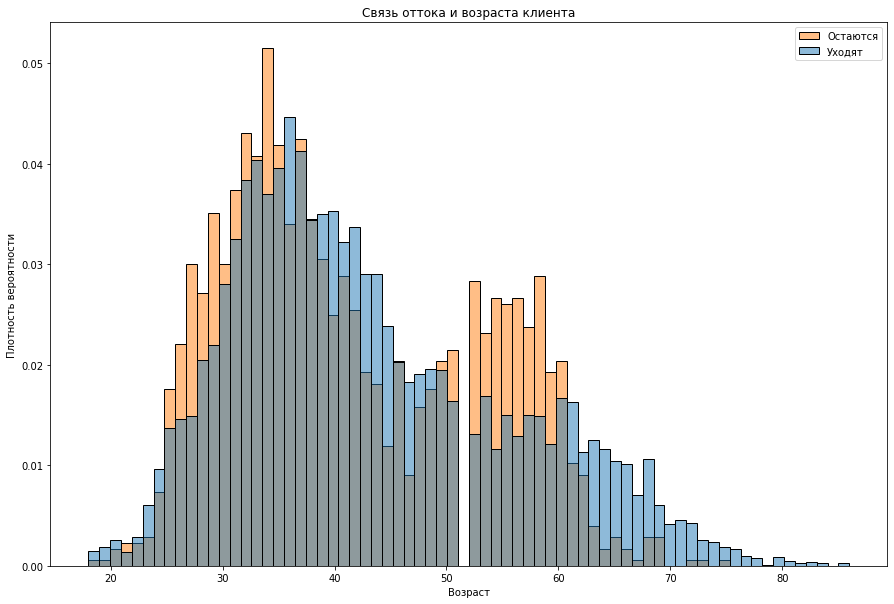

In [27]:
histplot_churn ('age', 'Связь оттока и возраста клиента', 'Возраст')

Доли уходящих клиентов выше, чем доли остающихся, среди клиентов возрастом до 25 лет, от 36 до 49 лет и старше 61 года.На основании этих результатов можно выделить 5 групп клиентов с распределением по возрасту. Создадим группы 1 - возраст до 25 лет, 2 -  25-36 лет, 3 -  37-48 лет, 4 - 49-61 лет, 5 - старше 61 года

In [28]:
data['age_category'] = 0
for i in range(len(data)):
    if data.loc[i, 'age'] <= 25:
        data.loc[i, 'age_category'] = 1
    elif 25<data.loc[i, 'age'] <=36:
        data.loc[i, 'age_category'] = 2
    elif 36<data.loc[i, 'age'] <=48:
        data.loc[i, 'age_category'] = 3
    elif 48<data.loc[i, 'age'] <=61:
        data.loc[i, 'age_category'] = 4
    elif data.loc[i, 'age'] > 61:
        data.loc[i, 'age_category'] = 5

#data.head(20)

#### Связь оттока и баланса на счете

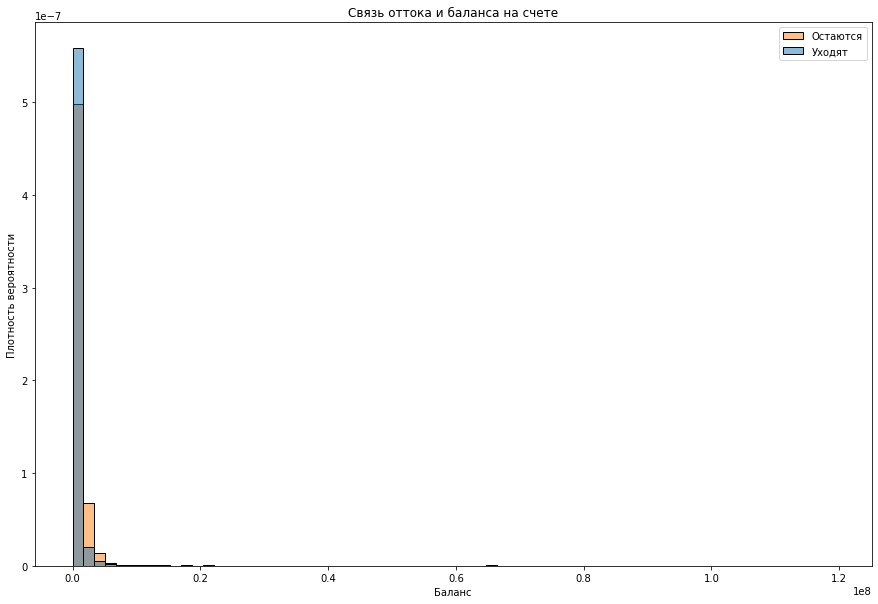

In [29]:
histplot_churn ('balance', 'Связь оттока и баланса на счете', 'Баланс')

график нечитаем из-за выбросов (клиенты с очень высоким балансом счета). Построю график без учета выбросов. 

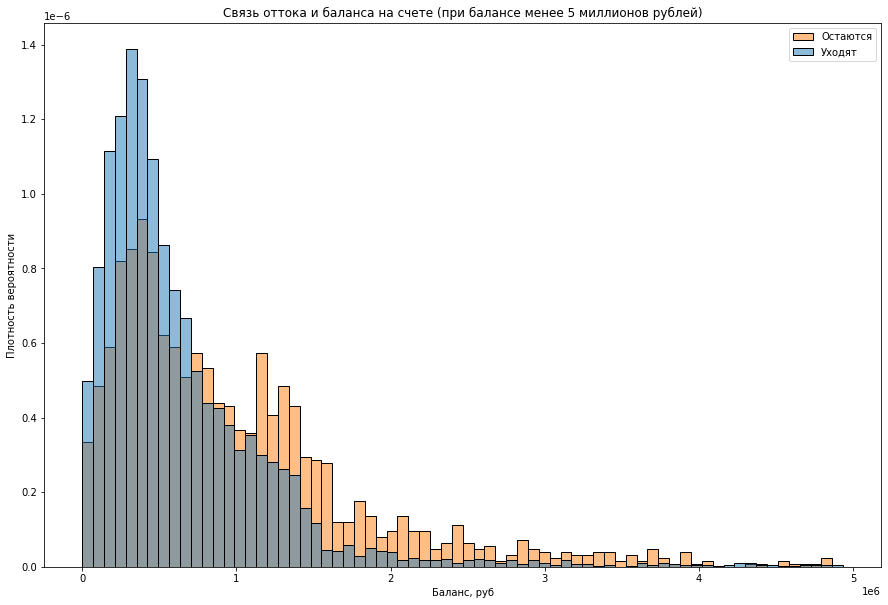

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data = data.loc[(data['balance'] <5000000)], x ='balance', hue = 'churn', stat="density", common_norm=False, ax=ax, bins = 70).\
                set(title='Связь оттока и баланса на счете (при балансе менее 5 миллионов рублей)');
plt.legend(labels=["Остаются","Уходят"])
plt.xlabel('Баланс, руб')
plt.ylabel('Плотность вероятности')
plt.show ()

Певый график стал понятен при верхней границе баланса менее 5 миллионов рублей. на стором остображены выбросы.
Доли уходящих клиентов выше, чем доли остающихся, среди клиентов с балансом менее 700 000 рублей. Клиентов с балансом более 4 миллионов относительно мало, нельзя сделать однозначных выводов. На основании этих результатов можно выделить 4 группы клиентов с распределением по балансу. Создадим группы 1 - баланс до 700 тысяч включительно, 2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов, 4 - нет данных о балансе

In [31]:
data['balance_category'] = 0
for i in range(len(data)):
    if data.loc[i, 'balance'] <= 700000:
        data.loc[i, 'balance_category'] = 1
    elif data.loc[i, 'balance'] >4000000:
        data.loc[i, 'balance_category'] = 3
    elif pd.isnull(data.loc[i, 'balance']):
        data.loc[i, 'balance_category'] = 4
    else:
        data.loc[i, 'balance_category'] = 2

#data.head(20)

#### Связь оттока и заработной платы клиента

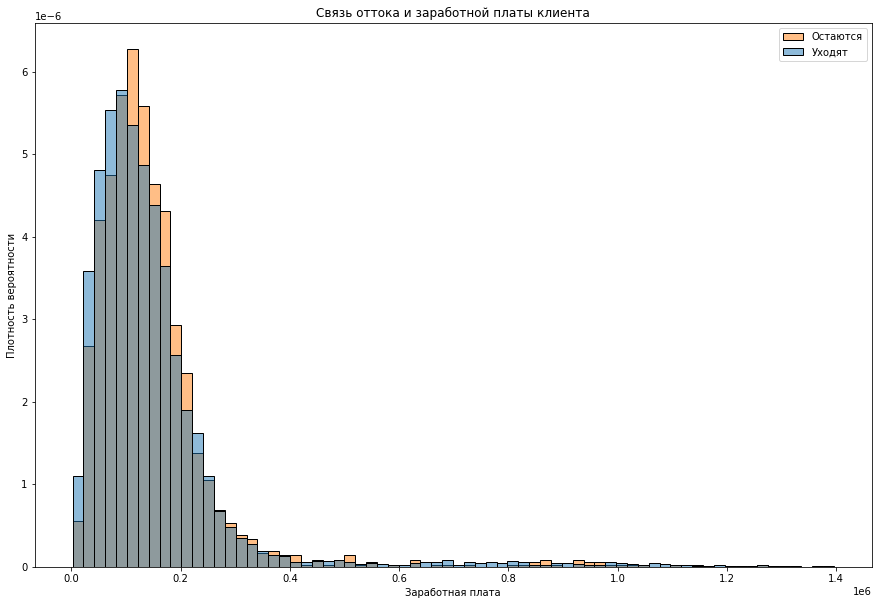

In [32]:
histplot_churn ('est_salary', 'Связь оттока и заработной платы клиента', 'Заработная плата')

Доли уходящих клиентов выше, чем доли остающихся, среди клиентов с зарплатой менее 100 000 рублей. Клиентов с зарплатой более 400000  относительно мало, нельзя сделать однозначных выводов. На основании этих результатов можно выделить 3 группы клиентов с распределением по зарплате. Создадим группы 1 - зарплата до 100 тысяч включительно, 2 - зарплата от 100 000 до 400 000, 3 - более 400 000

In [33]:
data['salary_category'] = 0
for i in range(len(data)):
    if data.loc[i, 'est_salary'] <= 100000:
        data.loc[i, 'salary_category'] = 1
    elif data.loc[i, 'est_salary'] >400000:
        data.loc[i, 'salary_category'] = 3
    else:
        data.loc[i, 'salary_category'] = 2

#data.head(20)

#### Вывод по анализу распределения количественных признаков

1. Кредитный рейтинг: доли уходящих клинетов выше, чем доли остающихся, среди клиентов с кредитным рейтингом до 820 и выше 940. Выделено 3 группы клиентов с распределением по рейтингу. Создадим группы 1 - рейтинг менее 820, 2 - рейтинг от 820 до 940, 3 - рейтинг более 940
2. Возраст: доли уходящих клиентов выше, чем доли остающихся, среди клиентов возрастом до 25 лет, от 36 до 49 лет и старше 61 года. Выделено 5 групп клиентов с распределением по возрасту. Создадим группы 1 - возраст до 25 лет, 2 - 25-36 лет, 3 - 37-48 лет, 4 - 49-61 лет, 5 - старше 61 года
3. Баланс на счете: доли уходящих клиентов выше, чем доли остающихся, среди клиентов с балансом менее 700 000 рублей. Клиентов с балансом более 4 миллионов относительно мало, нельзя сделать однозначных выводов. На основании этих результатов можно выделить 4 группы клиентов с распределением по балансу. Созданы группы 1 - баланс до 700 тысяч включительно, 2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов, 4 - нет данных о балансе
4. Заработная плата: доли уходящих клиентов выше, чем доли остающихся, среди клиентов с зарплатой менее 100 000 рублей. Клиентов с зарплатой более 400000 относительно мало, нельзя сделать однозначных выводов. Выделены 3 группы: 1 - зарплата до 100 тысяч включительно, 2 - зарплата от 100 000 до 400 000, 3 - более 400 000

### Анализ распределения категориальных признаков
В изначальном датафрейме к категориальным признакам относились city , gender, equity, Products, credit_card, last_activity, churn, missing_balance. На предыдущем этапе мы добавили категории score_category,  age_category, balance_category и salary_category

Для категориальных признаков построим столбчатые диаграммы с уровнями оттока (количество отточных в категории, делённое на общее количество в категории) и отмеченным средним уровнем оттока, либо, если мы исследуем продукты, то тепловую карту с долями пользующихся N продуктами в каждой из категорий

Для построения столбчатых диаграмм можно будем делать сводные таблицы pivot_table с уровнем оттока по категориям (или сделать группировку по категории с последующей аггрегацией информации об оттоке) 

In [34]:
# Запишем в переменную уровень среднего оттока по датасету
mean_churn = round(data['churn'].sum()/data['churn'].count()*100, 2)
mean_churn

18.23

#### Связь оттока и города проживания
##### Функция barplot_churn для столбчатой диаграммы уровня оттока

In [35]:
'''Функция barplot_churn создает агрегирующую таблицу по заданному столбцу и выводит столбчатую диаграмму уровня оттока 

На вход принимаются название столбца, подпись оси х и заголовок графика'''


def barplot_churn (column, xlabel, title):
#создаем агрегирующую таблицу
    data_groupby = (data.groupby(column, as_index=False)
      .agg({'churn': 'sum', 'user_id':'count'}))
    data_groupby['% оттока'] = round(data_groupby['churn']/data_groupby['user_id']*100, 2)
    print(data_groupby)
#выводим график
    data_groupby['% оттока'].plot.bar(figsize=(10, 5))
    plt.xlabel(xlabel)
    plt.ylabel('Уровень оттока, %')
    plt.xticks(np.arange(len(data_groupby)), data_groupby[column], rotation=45)
    plt.axhline(y = mean_churn, color = 'r', linestyle = '--', label = '18.24%, средний уровень оттока')
    plt.title (title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show();
    return 

        city  churn  user_id  % оттока
0     Ростов    265     1416     18.71
1    Рыбинск    436     2682     16.26
2  Ярославль   1117     5875     19.01


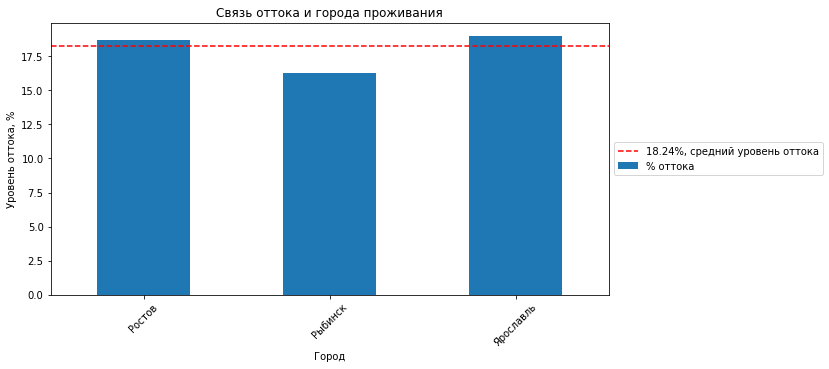

In [36]:
barplot_churn ('city', 'Город', 'Связь оттока и города проживания')

Уровень оттока в Рыбинске ниже среднего и составляет 16,29%, в Ростове и Ярославле - чуть выше среднего и составляет 18,71 и 19,01%, соответственно. Проживание в Рыбинске немного снижает вероятность оттока, но разница не значительна

#### Связь оттока и пола клиента

  gender  churn  user_id  % оттока
0      Ж    635     4982     12.75
1      М   1183     4991     23.70


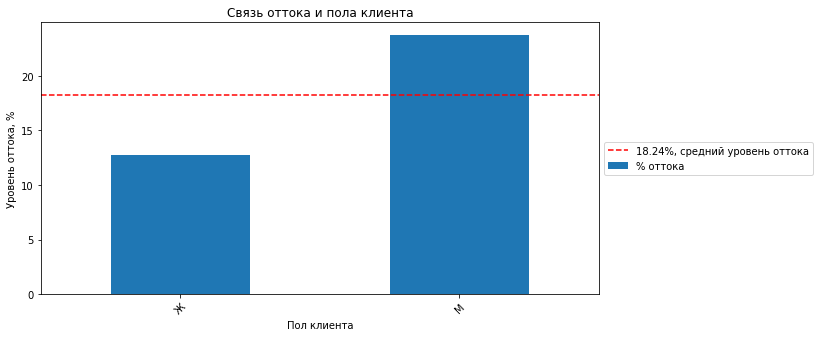

In [37]:
barplot_churn ('gender', 'Пол клиента', 'Связь оттока и пола клиента')

Уровень оттока среди женщин значительно ниже среднего и составляет 12,76%, среди мужчин- выше среднего и составляет 23,7%

#### Связь оттока и категории возраста

   age_category  churn  user_id  % оттока
0             1     62      376     16.49
1             2    694     3329     20.85
2             3    497     3282     15.14
3             4    517     2101     24.61
4             5     48      885      5.42


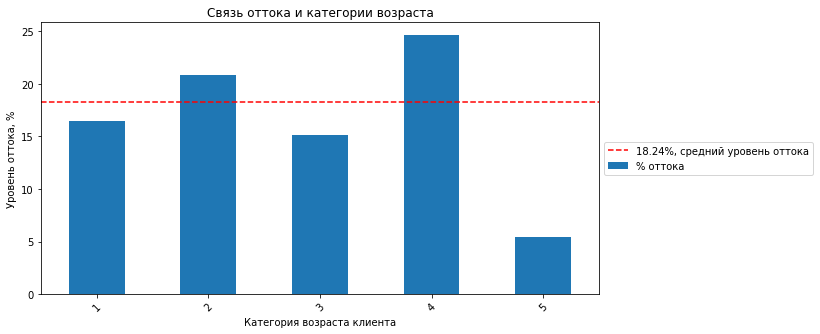

In [38]:
barplot_churn ('age_category', 'Категория возраста клиента', 'Связь оттока и категории возраста')

уровень оттока ниже среднего в группах 1, 3 и 5 выше среднего в группах 2 и 4, как и было при выделении групп. (группы 1 - возраст до 25 лет, 2 - 25-36 лет, 3 - 37-48 лет, 4 - 49-61 лет, 5 - старше 61 года)

#### Связь оттока и количества баллов собственности

   equity  churn  user_id  % оттока
0       0     90     2576      3.49
1       1     93      773     12.03
2       2    166     1051     15.79
3       3    321     1540     20.84
4       4    464     1847     25.12
5       5    576     1915     30.08
6       6     58      161     36.02
7       7     37       80     46.25
8       8      6       17     35.29
9       9      7       13     53.85


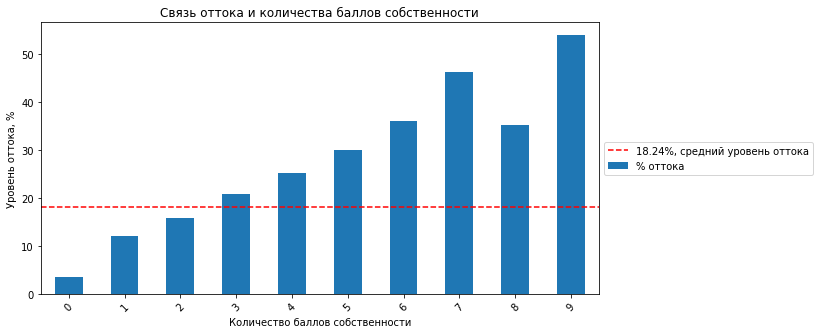

In [39]:
barplot_churn ('equity', 'Количество баллов собственности', 'Связь оттока и количества баллов собственности')

Процент оттока выше среди клиентов с большим количеством баллов собственности. Отток ниже среднего среди клиентов, у которых 2 и менее баллов и выше у клиентов, у которых 3 и более баллов.

#### Связь оттока и количества используемых продуктов банка

   products  churn  user_id  % оттока
0         1    235     3323      7.07
1         2    978     5119     19.11
2         3    297     1038     28.61
3         4    300      474     63.29
4         5      8       19     42.11


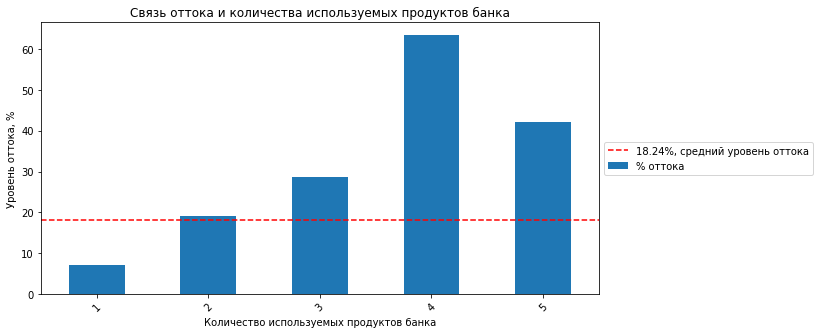

In [40]:
barplot_churn ('products', 'Количество используемых продуктов банка', 'Связь оттока и количества используемых продуктов банка')

Процент оттока выше среди клиентов использующих большее количество продуктов банка. Отток ниже среднего только среди клиентов, у которых только 1 продукт, примерно равен среднему у клиентов, у которых 2 продукта, и значительно выше среднего у клиентов с 3 и более продуктами. 

#### Связь оттока и наличия кредитной карты у клиента

   credit_card  churn  user_id  % оттока
0            0    815     3189     25.56
1            1   1003     6784     14.78


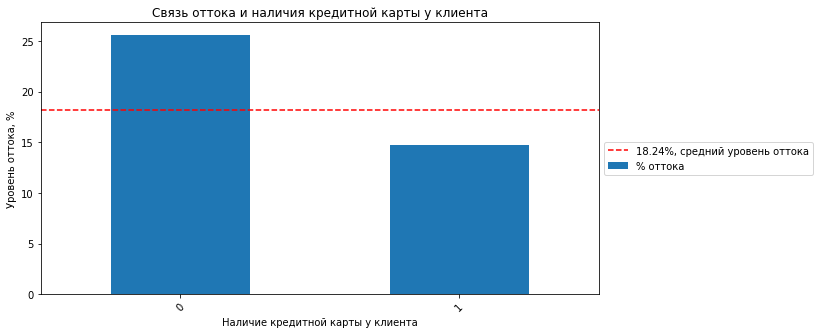

In [41]:
barplot_churn ('credit_card', 'Наличие кредитной карты у клиента', 'Связь оттока и наличия кредитной карты у клиента')

Среди клиентов с кредитными картами отток значительно ниже среднего (14,78%), среди клиентов без кредитных карт - значительно выше среднего (25,56%)

#### Связь оттока и активности клиента

   last_activity  churn  user_id  % оттока
0              0    541     4758     11.37
1              1   1277     5215     24.49


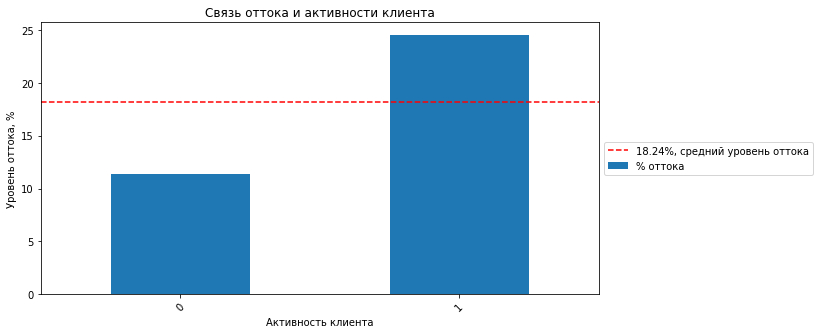

In [42]:
barplot_churn ('last_activity', 'Активность клиента', 'Связь оттока и активности клиента')

Среди активных клиентов отток значительно выше среднего (24,49%), среди неактивных клиентов - значительно ниже среднего (11.37%)

#### Связь оттока и отсутствия данных о балансе клиента

   missing_balance  churn  user_id  % оттока
0                0   1806     7695     23.47
1                1     12     2278      0.53


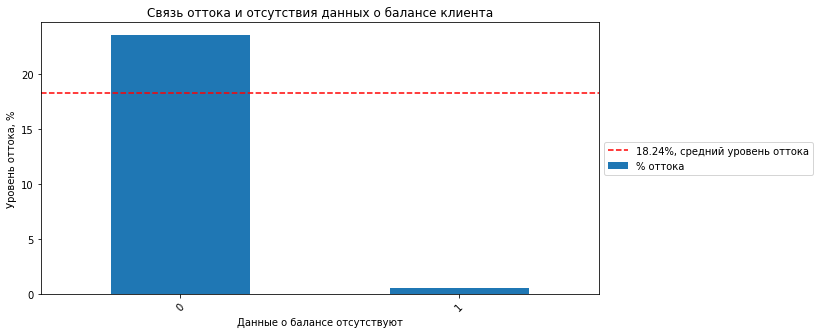

In [43]:
barplot_churn ('missing_balance', 'Данные о балансе отсутствуют', 'Связь оттока и отсутствия данных о балансе клиента')

Среди клиентов с известным балансом отток выше среднего (23,47%), а среди  клиентов, у которых отсутствуют данные о балансе - почти нулевой (0,53%). Возмжно, это новые клиенты, данные о балансе которых еще не подгрузились в базу

#### Связь оттока и категории баланса

   balance_category  churn  user_id  % оттока
0                 1    821     4798     17.11
1                 2    947     2786     33.99
2                 3     38      111     34.23
3                 4     12     2278      0.53


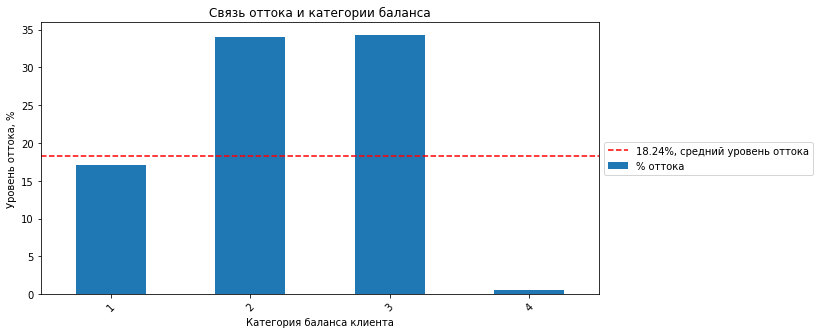

In [44]:
barplot_churn ('balance_category', 'Категория баланса клиента', 'Связь оттока и категории баланса')

уровень оттока ниже среднего в группе 1 и выше среднего в группах 2 и 3, как и было при выделении групп. В группе 4 уровень оттока минимален.
(группы 1 - баланс до 700 тысяч включительно, 2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов, 4 - нет данных о балансе)

#### Связь оттока и категории баллов кредитного рейтинга

   score_category  churn  user_id  % оттока
0               1    368     3397     10.83
1               2   1363     5934     22.97
2               3     87      642     13.55


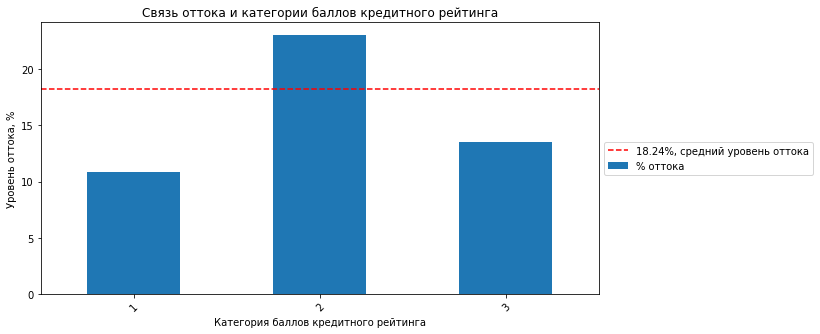

In [45]:
barplot_churn ('score_category', 'Категория баллов кредитного рейтинга', 'Связь оттока и категории баллов кредитного рейтинга')

уровень оттока ниже среднего в группах 1 и 3 и выше среднего в группе 2, как и было при выделении групп. (1 - рейтинг менее 820, 2 - рейтинг от 820 до 940, 3 - рейтинг более 940)

#### Связь оттока и категории заработной платы клиента

   salary_category  churn  user_id  % оттока
0                1    624     3924     15.90
1                2   1144     5714     20.02
2                3     50      335     14.93


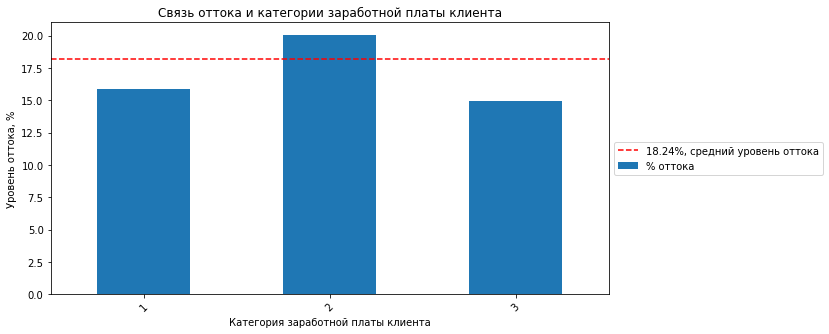

In [46]:
barplot_churn ('salary_category', 'Категория заработной платы клиента', 'Связь оттока и категории заработной платы клиента')

уровень оттока ниже среднего в группах 1 и 3 и выше среднего в группе 2, как и было при выделении групп. (группы 1 - зарплата до 100 тысяч включительно, 2 - зарплата от 100 000 до 400 000, 3 - более 400 000)

#### Вывод по анализу распределения категориальных признаков
1. Город проживания: Уровень оттока в Рыбинске ниже среднего и составляет 16,29%, в Ростове и Ярославле - чуть выше среднего и составляет 18,71 и 19,01%, соответственно.
2. Пол клиента: Уровень оттока среди женщин значительно ниже среднего и составляет 12,76%, среди мужчин- выше среднего и составляет 23,7%
3. Возраст: уровень оттока ниже среднего в группах 1, 3 и 5 выше среднего в группах 2 и 4, как и было при выделении групп. (группы 1 - возраст до 25 лет, 2 - 25-36 лет, 3 - 37-48 лет, 4 - 49-61 лет, 5 - старше 61 года)
4. Количество баллов собственности: Процент оттока выше среди клиентов с большим количеством баллов собственности. Отток ниже среднего среди клиентов, у которых 2 и менее баллов и выше у клиентов, у которых 3 и более баллов.
5. количество используемых продуктов: Процент оттока выше среди клиентов использующих большее количество продуктов банка. Отток ниже среднего только среди клиентов, у которых только 1 продукт, примерно равен среднему у клиентов, у которых 2 продукта, и значительно выше среднего у клиентов с 3 и более продуктами.
6. наличие кредитной карты: Среди клиентов с кредитными картами отток значительно ниже среднего (14,78%), среди клиентов без кредитных карт - значительно выше среднего (25,56%)
7. Активность клиента: Среди активных клиентов отток значительно выше среднего (24,49%), среди неактивных клиентов - значительно ниже среднего (11.37%)
8. Отсутствие данных о балансе: Среди клиентов с известным балансом отток выше среднего (23,47%), а среди клиентов, у которых отсутствуют данные о балансе - почти нулевой (0,53%). Возмжно, это новые клиенты, данные о балансе которых еще не подгрузились в базу
9. Категория баланса: уровень оттока ниже среднего в группе 1 и выше среднего в группах 2 и 3, как и было при выделении групп. В группе 4 уровень оттока минимален. (группы 1 - баланс до 700 тысяч включительно, 2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов, 4 - нет данных о балансе)
10. Кредитный рейтинг: уровень оттока ниже среднего в группах 1 и 3 и выше среднего в группе 2, как и было при выделении групп. (1 - рейтинг менее 820, 2 - рейтинг от 820 до 940, 3 - рейтинг более 940)
11. Заработная плата: уровень оттока ниже среднего в группах 1 и 3 и выше среднего в группе 2, как и было при выделении групп. (группы 1 - зарплата до 100 тысяч включительно, 2 - зарплата от 100 000 до 400 000, 3 - более 400 000)


### Выделение значимых признаков отточности 

На основании проанализированных связей уровня оттока и признаков клиента можно выделить признаки отточности:
1. Город проживания: нет выраженного влияния.
2. Пол клиента: мужской
3. Возраст: группы 2 и 4 (2 - 25-36 лет, 4 - 49-61 лет)
4. Количество баллов собственности: 3 и более баллов.
5. количество используемых продуктов: 3 и более продуктов.
6. наличие кредитной карты: отсутсвует кредитная карта
7. Активность клиента: активный клиент
8. Отсутствие данных о балансе: баланс известен
9. Категория баланса: группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)
10. Кредитный рейтинг:группа 2 (2 - рейтинг от 820 до 940)
11. Заработная плата: группа 2 (2 - зарплата от 100 000 до 400 000)

Признаки неотточного клиента

1. Город проживания: нет выраженного влияния.
2. Пол клиента: женский
3. Возраст: группа 1, 3 и 5 (группы 1 - возраст до 25 лет, 3 - 37-48 лет, 5 - старше 61 года)
4. Количество баллов собственности:  2 и менее баллов
5. количество используемых продуктов: 1 продукт
6. наличие кредитной карты: есть карта
7. Активность клиента: неактивный клиент
8. Отсутствие данных о балансе: нет данных
9. Категория баланса: группа 1 (баланс до 700 тысяч включительно)
10. Кредитный рейтинг: группы 1 и 3 (1 - рейтинг менее 820, 3 - рейтинг более 940)
11. Заработная плата: группы 1 и 3 (группы 1 - зарплата до 100 тысяч включительно, 3 - более 400 000)

### Сравнение портретов типичных клиентов
взять подходящие средние тенденции и посчитать для каждой характеристики, на сколько процентов это число больше (меньше) у отточных по сравнению с неотточными.
Разделим клиентов на 6 групп - отточные и неотточные по городам.

#### Функция means_by_churn для оценки разницы средних в группах

In [47]:
'''Функция means_by_churn  рассчитывает разницу в количественном среднем показателе у отточных и неотточных клиентов по городам

На вход принимается 2 аргумента: характеристика для вывода и название столбца для анализа'''

def means_by_churn (print_characteristic, column):
    for city in ["Ярославль", "Ростов","Рыбинск"]:
        print('Разница в среднем', print_characteristic, 'у отточных и неотточных клиентов в городе', city, 'составляет', 
              round(100 - round(data.query('churn == 1 and city == @city')[column].mean()/
                                data.query('churn == 0 and city ==@city')[column].mean()*100,2), 2), "%")
    return

In [48]:
means_by_churn ('возрасте', 'age')

Разница в среднем возрасте у отточных и неотточных клиентов в городе Ярославль составляет 3.89 %
Разница в среднем возрасте у отточных и неотточных клиентов в городе Ростов составляет 3.69 %
Разница в среднем возрасте у отточных и неотточных клиентов в городе Рыбинск составляет 2.95 %


In [49]:
means_by_churn ('количестве баллов собственности', 'equity')

Разница в среднем количестве баллов собственности у отточных и неотточных клиентов в городе Ярославль составляет -67.61 %
Разница в среднем количестве баллов собственности у отточных и неотточных клиентов в городе Ростов составляет -39.72 %
Разница в среднем количестве баллов собственности у отточных и неотточных клиентов в городе Рыбинск составляет -48.37 %


In [50]:
means_by_churn ('балансе на счете', 'balance')

Разница в среднем балансе на счете у отточных и неотточных клиентов в городе Ярославль составляет -56.02 %
Разница в среднем балансе на счете у отточных и неотточных клиентов в городе Ростов составляет -52.55 %
Разница в среднем балансе на счете у отточных и неотточных клиентов в городе Рыбинск составляет -43.48 %


In [51]:
means_by_churn ('заработной плате', 'est_salary')

Разница в среднем заработной плате у отточных и неотточных клиентов в городе Ярославль составляет 1.76 %
Разница в среднем заработной плате у отточных и неотточных клиентов в городе Ростов составляет -13.74 %
Разница в среднем заработной плате у отточных и неотточных клиентов в городе Рыбинск составляет 1.47 %


#### Функция categories_by_churn для анализа категориальных переменных 
напишем еще одну функцию для анализа оттока в зависимости от категориальных переменных с рааспределением по городам

In [52]:
'''Функция categories_by_churn  рассчитывает разницу в категориальных показателях у отточных и неотточных клиентов по городам
и сравнивает ее со средним уровнем оттока по датасету

На вход принимается 1 аргумент: название столбца для анализа'''

def categories_by_churn (category):
    table = data[['city', category, 'churn']].groupby(['city', category], as_index=False).\
                    mean().sort_values(by = 'churn', ascending = False)
    table['churn'] = round(table['churn']*100, 2)
    table['churn/mean_churn, %'] = round(table['churn']/mean_churn*100-100, 2)
    display(table.style.background_gradient(axis=None, vmin = 10))
    return

In [53]:
categories_by_churn('salary_category')

,city,salary_category,churn,"churn/mean_churn, %"
2,Ростов,3,41.670000,128.580000
1,Ростов,2,20.920000,14.760000
7,Ярославль,2,20.490000,12.400000
4,Рыбинск,2,18.480000,1.370000
6,Ярославль,1,16.910000,-7.240000
0,Ростов,1,16.150000,-11.410000
8,Ярославль,3,15.750000,-13.600000
3,Рыбинск,1,13.890000,-23.810000
5,Рыбинск,3,7.250000,-60.230000


In [54]:
categories_by_churn('gender')

,city,gender,churn,"churn/mean_churn, %"
1,Ростов,М,25.620000,40.540000
5,Ярославль,М,23.670000,29.840000
3,Рыбинск,М,22.770000,24.900000
4,Ярославль,Ж,14.150000,-22.380000
0,Ростов,Ж,12.280000,-32.640000
2,Рыбинск,Ж,10.050000,-44.870000


In [55]:
categories_by_churn('age_category')

,city,age_category,churn,"churn/mean_churn, %"
13,Ярославль,4,25.330000,38.950000
3,Ростов,4,23.930000,31.270000
8,Рыбинск,4,23.650000,29.730000
11,Ярославль,2,22.340000,22.550000
1,Ростов,2,19.610000,7.570000
2,Ростов,3,18.790000,3.070000
10,Ярославль,1,18.180000,-0.270000
6,Рыбинск,2,17.810000,-2.300000
12,Ярославль,3,15.060000,-17.390000
5,Рыбинск,1,14.950000,-17.990000


In [56]:
categories_by_churn('equity')

,city,equity,churn,"churn/mean_churn, %"
9,Ростов,9,66.670000,265.720000
29,Ярославль,9,62.500000,242.840000
27,Ярославль,7,57.140000,213.440000
18,Рыбинск,8,50.000000,174.270000
26,Ярославль,6,39.800000,118.320000
16,Рыбинск,6,37.140000,103.730000
17,Рыбинск,7,36.840000,102.080000
8,Ростов,8,33.330000,82.830000
25,Ярославль,5,32.600000,78.830000
28,Ярославль,8,30.000000,64.560000


In [57]:
categories_by_churn('products')

,city,products,churn,"churn/mean_churn, %"
9,Рыбинск,5,100.000000,448.550000
13,Ярославль,4,64.820000,255.570000
8,Рыбинск,4,64.650000,254.640000
3,Ростов,4,54.410000,198.460000
14,Ярославль,5,50.000000,174.270000
12,Ярославль,3,30.210000,65.720000
2,Ростов,3,28.420000,55.900000
7,Рыбинск,3,21.210000,16.350000
11,Ярославль,2,19.830000,8.780000
1,Ростов,2,18.880000,3.570000


In [58]:
categories_by_churn('credit_card')

,city,credit_card,churn,"churn/mean_churn, %"
4,Ярославль,0,29.020000,59.190000
2,Рыбинск,0,22.160000,21.560000
0,Ростов,0,21.730000,19.200000
1,Ростов,1,16.420000,-9.930000
5,Ярославль,1,15.210000,-16.570000
3,Рыбинск,1,12.960000,-28.910000


In [59]:
categories_by_churn('last_activity')

,city,last_activity,churn,"churn/mean_churn, %"
5,Ярославль,1,26.360000,44.600000
1,Ростов,1,23.240000,27.480000
3,Рыбинск,1,21.460000,17.720000
0,Ростов,0,13.570000,-25.560000
4,Ярославль,0,11.600000,-36.370000
2,Рыбинск,0,9.560000,-47.560000


In [60]:
categories_by_churn('missing_balance')

,city,missing_balance,churn,"churn/mean_churn, %"
4,Ярославль,0,25.110000,37.740000
0,Ростов,0,22.350000,22.600000
2,Рыбинск,0,20.650000,13.270000
5,Ярославль,1,0.550000,-96.980000
3,Рыбинск,1,0.510000,-97.200000
1,Ростов,1,0.430000,-97.640000


In [61]:
categories_by_churn('balance_category')

,city,balance_category,churn,"churn/mean_churn, %"
6,Рыбинск,3,42.110000,130.990000
2,Ростов,3,40.000000,119.420000
9,Ярославль,2,37.580000,106.140000
10,Ярославль,3,32.180000,76.520000
1,Ростов,2,31.440000,72.460000
5,Рыбинск,2,27.190000,49.150000
0,Ростов,1,17.770000,-2.520000
8,Ярославль,1,17.080000,-6.310000
4,Рыбинск,1,16.790000,-7.900000
11,Ярославль,4,0.550000,-96.980000


In [62]:
categories_by_churn('score_category')

,city,score_category,churn,"churn/mean_churn, %"
7,Ярославль,2,24.440000,34.060000
1,Ростов,2,23.050000,26.440000
4,Рыбинск,2,19.750000,8.340000
2,Ростов,3,14.060000,-22.870000
8,Ярославль,3,14.040000,-22.980000
0,Ростов,1,12.590000,-30.940000
5,Рыбинск,3,12.120000,-33.520000
3,Рыбинск,1,10.700000,-41.310000
6,Ярославль,1,10.420000,-42.840000


#### Формулирование портретов клиентов
Можем выделить значимые характеристики оттока по городам и сформировать портреты отточных и неотточных клиентов:

**Отточные клиенты (значимой принимаем разницу в уровне оттока более 10%):**
1.	Город проживания: Ярославль.
2.	Пол клиента: мужской
3.	Возраст: группы 2 и 4 (2 - 25-36 лет, 4 - 49-61 лет)
4.	Количество баллов собственности: 9, 7, 6, 5, 8, 4 баллов.
5.	количество используемых продуктов: 4, 5, 3 продуктов.
6.	наличие кредитной карты: отсутсвует кредитная карта
7.	Активность клиента: активный клиент
8.	Отсутствие данных о балансе: баланс известен
9.	Категория баланса: группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)
10.	Кредитный рейтинг:группа 2 (2 - рейтинг от 820 до 940)
11.	Заработная плата: неважна


1.	Город проживания: Ростов.
2.	Пол клиента: мужской
3.	Возраст: группа 4 (49-61 лет)
4.	Количество баллов собственности: 9, 8, 5, 4 баллов.
5.	количество используемых продуктов: 4, 3 продуктов.
6.	наличие кредитной карты: отсутсвует кредитная карта
7.	Активность клиента: активный клиент
8.	Отсутствие данных о балансе: баланс известен
9.	Категория баланса: группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)
10.	Кредитный рейтинг:группа 2 (2 - рейтинг от 820 до 940)
11.	Заработная плата: группа 3


1.	Город проживания: Рыбинск
2.	Пол клиента: мужской
3.	Возраст: группа 4 (49-61 лет)
4.	Количество баллов собственности: 8, 6, 7,5, 4.
5.	количество используемых продуктов: 5, 4, 3 продуктов.
6.	наличие кредитной карты: отсутсвует кредитная карта
7.	Активность клиента: активный клиент
8.	Отсутствие данных о балансе: баланс известен
9.	Категория баланса: группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)
10.	Кредитный рейтинг:неважен
11.	Заработная плата: неважна



**Неотточные клиенты (значимой принимаем разницу в уровне оттока более на 10%):**
1.	Город проживания: Ярославль.
2.	Пол клиента: женский
3.	Возраст: группы 5, 3
4.	Количество баллов собственности: 0, 1, 2 баллов.
5.	количество используемых продуктов: 1 продукт.
6.	наличие кредитной карты: есть кредитная карта
7.	Активность клиента: неактивный клиент
8.	Отсутствие данных о балансе: баланс неизвестен
9.	Категория баланса: группа 4
10.	Кредитный рейтинг: группа 1, 3
11.	Заработная плата: группа 3


1.	Город проживания: Ростов.
2.	Пол клиента: женский
3.	Возраст: группа 5, 1
4.	Количество баллов собственности: 0, 1 баллов.
5.	количество используемых продуктов: 5, 1 продуктов.
6.	наличие кредитной карты: есть кредитная карта
7.	Активность клиента: неактивный клиент
8.	Отсутствие данных о балансе: баланс неизвестен
9.	Категория баланса: группа 4
10.	Кредитный рейтинг:группа 1, 3
11.	Заработная плата: группа 1


1.	Город проживания: Рыбинск
2.	Пол клиента: женский
3.	Возраст: группа 5, 3, 1
4.	Количество баллов собственности: 9, 0 , 1, 2
5.	количество используемых продуктов: 1 продукт.
6.	наличие кредитной карты: есть кредитная карта
7.	Активность клиента: неактивный клиент
8.	Отсутствие данных о балансе: баланс неизвестен
9.	Категория баланса: группа 4
10.	Кредитный рейтинг: группа 1, 3
11.	Заработная плата: группа 1, 3


### Корреляционный анализ (с использованием библиотеки phik)

interval columns not set, guessing: ['user_id', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'missing_balance', 'female', 'male', 'rostov', 'rybinsk', 'yaroslavl', 'score_category', 'age_category', 'balance_category', 'salary_category']


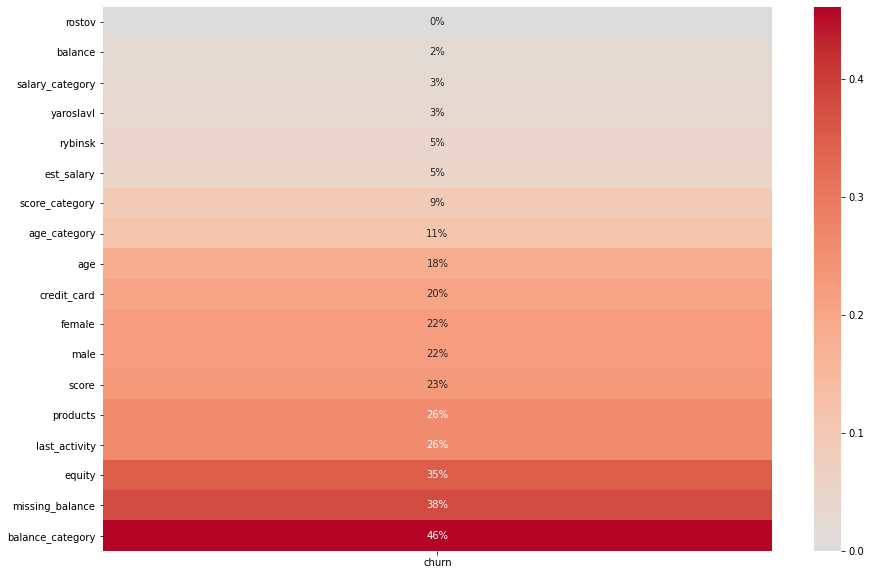

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data.phik_matrix().loc[:,['churn']].drop(['churn', 'city', 'gender', 'user_id']).\
            sort_values('churn'), annot = True, fmt=".0%", cmap = "coolwarm", center =0);

Согласно результатам корреляционного анализа наибольшее влияние на отток оказывают в порядке убывания(уровень корреляции в скобках): баланс на счете (46%) и его наличие (38%), количество баллов собственности (35%), активность клиента (26%), количество используемых продуктов (26%), кредитный рейтинг (23%), пол (22%), наличие кредитной карты (20%) и возраст клиентов (18%). Будем учитывать это при дальнейшей сегментации на группы.

## Шаг 4. Проверка статистических гипотез

### Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались 
(применить t-критерий Стьюдента и критерий Манна-Уитни, объяснить расхождения, если они возникнут, выбрать, какому критерию стоит доверять сильнее)

Сформулируем нулевую и альтернативную гипотезы. Нулевая гипотеза это гипотеза об отсутствии различий. Альтернативная гипотеза противоречит нулевой и говорит о возможном отклонении и в большую, и в меньшую стороны (двусторонняя).

H₀: Доход ушедших и оставшихся клиентов одинаков 

H₁: Доход ушедших и оставшихся клиентов отличается 

#### тест Шапиро-Уилка
Перед проведением тестов проверим распределение на нормальность методом Шапиро-Уилка

H₀: данные выборки распределены нормально

H₁: данные выборки не имеют нормального распределения

In [64]:
shapiro(data['est_salary'])

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6190118789672852, pvalue=0.0)

Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

####  t-тест Стьюдента

Выберем метод статистической оценки. Мы проверяем гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, поэтому исползуем scipy.stats.ttest_ind (array1, array2, equal_var).

Необходимые для этого условия: Генеральные совокупности не зависят друг от друга. Выборочные средние **нормально распределены** (Благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние будут распределены нормально вокруг истинного среднего этой совокупности). Мы не можем уверждать, что дисперсии рассматриваемых генеральных совокупностей равны (хотя выборки достаточно велики (30 и больше значений), они не равны по размеру между собой), поэтому ставим equal_var =False)

критический уровень статистической значимости alpha задам 0,05

In [66]:
alpha = 0.05 # 
results = st.ttest_ind(data.query('churn==1')['est_salary'], data.query('churn==0')['est_salary'], equal_var =False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


Вывод: На основании проверенных гипотез можно сказать, что вероятность случайно получить такое или большее различие равна 85%. Это слишком большая вероятность, чтобы делать вывод о значимом различии между зарплатами клиентов. То есть наше предположение о рвенстве дохода уходящих и остающихся клиентов нельзя отрицать.

#### критерий Манна-Уитни
U- критерий Манна-Уитни используется для сравнения различий между двумя выборками, когда распределение выборки не является нормальным

In [67]:
alpha = 0.05 # 
results = st.mannwhitneyu(data.query('churn==1')['est_salary'], data.query('churn==0')['est_salary'],\
                               alternative='two-sided')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.00016830729188229058
Отвергаем нулевую гипотезу


Вывод: По результатам теста Манна-Уитни можно отвергнуть нулевую гипотезу и сказать, что Доход ушедших и оставшихся клиентов отличается. Поскольку критерий Манна-Уитни используется для сравнения различий между двумя выборками, когда распределение выборки не является нормальным, считаю его результат приоритетным в данном случае.

### Сформулируйте и проверьте статистическую гипотезу относительно представленных данных, которая поможет внести ясность в исследование

#### Гипотеза по категории кредитного рейтинга
По результатам корреляционного анализа разница по категориям кредитного рейтинга составила 9%, при этом нераспределенный на категории показатель score показал значительно большую корреляцию 23%.

H₀: Категория баллов кредитного рейтинга ушедших и оставшихся клиентов одинаковы

H₁: Категория баллов кредитного рейтинга ушедших и оставшихся клиентов отличается 

In [68]:
shapiro(data['score_category'])

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.7379295825958252, pvalue=0.0)

Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

In [69]:
alpha = 0.05 # 
results = st.ttest_ind(data.query('churn==1')['score_category'], data.query('churn==0')['score_category'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1068088069245851e-23
Отвергаем нулевую гипотезу


In [70]:
alpha = 0.05 # 
results = st.mannwhitneyu(data.query('churn==1')['score_category'], data.query('churn==0')['score_category'],\
                               alternative='two-sided')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.76726189044193e-29
Отвергаем нулевую гипотезу


По результатам обоих тестов можно отвергнуть нулевую гипотезу и сказать, что категория баллов кредитного рейтинга ушедших и оставшихся клиентов отличается.

## Шаг 5. Формулирование промежуточного итога о том, какие показатели статистически влияют на отток
Согласно результатам корреляционного анализа наибольшее влияние на отток оказывают в порядке убывания (уровень корреляции в скобках): баланс на счете (46%) и его наличие (38%), количество баллов собственности (35%), активность клиента (26%), количество используемых продуктов (26%), кредитный рейтинг (23%), пол (22%), наличие кредитной карты (20%) и возраст клиентов (18%). Будем учитывать это при дальнейшей сегментации на группы.

|Показатель |Сравнение портретов/гипотезы|Корреляции|Распределения в разрезе оттока|
| :--- | :---: | :---: | :--- |
|score      |нет связи                   |есть связь          |группа 2 (2 - рейтинг от 820 до 940)                              |
|city       |нет связи                   |нет связи          |нет выраженного влияния                              |
|gender     |есть связь                   |есть связь          | мужской пол                             |
|age        |нет связи                   |есть связь          |группы 2 и 4 (2 - 25-36 лет, 4 - 49-61 лет)                              |
|equity     |есть связь                   |есть связь          |3 и более баллов                              |
|balance    |есть связь                   |нет связи          |группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)                              |
|products   |есть связь                   |есть связь          |3 и более продуктов                              |
|credit_card|есть связь                   |есть связь          |отсутсвует кредитная карта                             |
|last_activity|есть связь                 |есть связь          |активный клиент                              |
|est_salary |нет связи                   |нет связи          |группа 2 (2 - зарплата от 100 000 до 400 000)                              |
|missing_balance     |есть связь                   |есть связь          |баланс известен                              |
|balance_category    |есть связь                   |есть связь          |группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)                              |
|age_category   |есть связь                   |есть связь          |группы 2 и 4 (2 - 25-36 лет, 4 - 49-61 лет)                              |
|score_category|есть связь                   |есть связь          |группа 2 (2 - рейтинг от 820 до 940)                              |
|salary_category|нет связи                 |нет связи          |группа 2 (2 - зарплата от 100 000 до 400 000)                              |

## Шаг 6. Сегментация на основе стратегических показателей

#### функция segment_churn для сегментации
Напишу функцию, позволющую сделать срез по выбранному условию, рассчитать средний отток клиентов в этой группе, посчитать количество клиентов в этой группе и добавить эту колонку в таблицу segment_table, по которой потом будет произведен анализ сегментов

Мы ищем сегменты в 500-2000 человек.

In [71]:
segment_table = pd.DataFrame(columns=['A'], index=(0, 1, 2, 'condition'))
segment_table

,A
0,NaN
1,NaN
2,NaN
condition,NaN


In [72]:
''' функция segment_churn добавляет в таблицу segment_table колонку показателей оттока в срезе, сделанном по заданному условию
колонка добавляется при условии количества клиентов в сегменте от 490 до 2000
На вход принимается условие среза и название новой колонки'''

def segment_churn (query_condition, column_name):
    column = data.query(query_condition).agg({"churn":["mean","sum","count"]}).reset_index(drop = True)
    if 490<column.loc[2, 'churn']<=2000:
        add_condition =column.append(pd.Series(query_condition, index=column.columns, name='condition'))
        segment_table[column_name] = add_condition
#        print(column)
    return 

Напишу функцию для перебора сочетаний значений условия

In [73]:
conditions_list1 = ['gender == "М"', 'equity >=3' , 'credit_card == 0', 'score_category == 2', 'salary_category == 3',\
                    'age_category == 2', 'balance_category == 2', 'products >=3']
conditions_list2 = ['gender == "М"', 'equity >=3' , 'credit_card == 1', 'score_category == 2', 'salary_category == 3',\
                    'age_category == 6', 'balance_category == 2', 'products >=3']
conditions_list3 = ['gender == "F"', 'equity >=3' , 'credit_card == 0', 'score_category == 2', 'salary_category == 3',\
                    'age_category == 2', 'balance_category == 2', 'products >=3']
conditions_list4 = ['gender == "М"', 'equity >=3' , 'credit_card == 0', 'score_category == 2', 'salary_category == 3',\
                    'age_category == 4', 'balance_category >= 2', 'products >=3']

#### функция conditions_combinations для комбинаций условий

In [74]:
''' функция conditions_combinations перебирает все комбинации без повторений условий из переданного листа и 
применяет функцию segment_churn к результату
На вход принимается список с условиями'''

def conditions_combinations(conditions_list):
    for i in range (2, 5):
        column_name=i*10
        delimiter = ','
        for x in combinations(conditions_list, i):
            column_name+=1
            conditions = re.split(',', delimiter.join(x))
            query_condition = " and ".join(conditions)
    #        print(query_condition)
    #        print (column_name)
            segment_churn (query_condition, column_name)
    return

In [75]:
conditions_combinations (conditions_list1)
conditions_combinations (conditions_list2)
conditions_combinations (conditions_list3)
conditions_combinations (conditions_list4)
#segment_table

Транспонируем таблицу segment_table для анализа, отсортируем полученные сегменты по уровню оттока и переименуем столбцы


In [76]:
segment_table = segment_table.T.drop(labels = ['A'],axis = 0).sort_values(by = 0, ascending = False)

In [77]:
segment_table.columns = ['mean_churn', 'sum_churn', 'count_clients', 'condition']

with option_context('display.max_colwidth', None):
    display(segment_table)

,mean_churn,sum_churn,count_clients,condition
82,0.587902,311.0,529.0,score_category == 2 and balance_category >= 2 and products >=3
41,0.569444,369.0,648.0,"gender == ""М"" and equity >=3 and credit_card == 0 and score_category == 2"
44,0.56912,317.0,557.0,"gender == ""М"" and equity >=3 and credit_card == 0 and balance_category >= 2"
36,0.538088,332.0,617.0,"gender == ""М"" and equity >=3 and products >=3"
66,0.532097,373.0,701.0,equity >=3 and balance_category >= 2 and products >=3
48,0.516227,509.0,986.0,"gender == ""М"" and equity >=3 and score_category == 2 and balance_category >= 2"
60,0.5,401.0,802.0,equity >=3 and score_category == 2 and products >=3
27,0.5,376.0,752.0,"gender == ""М"" and products >=3"
78,0.494949,441.0,891.0,equity >=3 and credit_card == 0 and score_category == 2 and balance_category >= 2
31,0.470258,419.0,891.0,"gender == ""М"" and equity >=3 and credit_card == 0"


Выделены сегменты отточных пользователей, ранжированы в порядке убывания отточности. 
Топ 10 отточных сегментов: 
1. отток 61,8%, 497 клиентов - score_category == 2 and balance_category == 2 and products >=3 
2. отток 58,8%, 519 клиентов - gender == "М" and equity >=3 and credit_card == 0 and balance_category == 2
3. отток 57%, 552 клиента -gender == "М" and credit_card == 0 and balance_category == 2
4. отток 56,9%, 648 клиентов - gender == "М" and equity >=3 and credit_card == 0 and score_category == 2
5. отток 54%, 665 клиентов - equity >=3 and balance_category == 2 and products >=3
6. отток 53%, 540 клиентов equity >=3 and score_category == 2 and age_category == 2 and balance_category == 2
7. отток 52,5%, 571 клиент score_category == 2 and age_category == 2 and balance_category == 2
8. отток 52%, 962 клиента gender == "М" and equity >=3 and score_category == 2 and balance_category == 2
9. отток 50%, 752 клиента gender == "М" and products >=3
10. отток 50%, 802 клиента equity >=3 and score_category == 2 and products >=3





Если выбирать именно 3 сегмента, то выберу менее пересекающиеся:
1. Клиенты со средним кредитным рейтингом, средним балансом счета, пользующиеся большим количеством продуктов (отток 61,8%, 497 клиентов). Предположу, что клиенты, обладающие не очень высоким, но и не низким кредитным рейтингом могут получать неожиданный для них отказ по кредиту, если они считают свои вводные достаточными, а банк  - нет. Это сильно снижает лояльность. При этом эти клиенты пользуются большим количеством продуктов банка и имеют средний баланс счета. Для них рекомендую разработать особые условия кредитования, облегчающие выдачу кредита в этой группе. К тому же помним, что наличие кредитных карт уменьшает отточность. Также можно предложить бонусный продукт, раз они активно их используют.
2. Мужчины со средними баллами собственности и средним балансом счета, без кредитной карты (отток 58,8%, 519 клиентов). Этим клиентам можно предложить особые условия получения кредитной карты, облегчающие выдачу кредитной карты, см выше про группу баланса 2. Возможно под особые условия под обеспечение собственностью, тк 3 балла собственности это средний уровень, ближе к низкому
3. Клиенты со средними баллами собственности и средним балансом, пользующиеся большим количеством продуктов (отток 54%, 665 клиентов). Клиентам, активно использующим продукты банка рекомендую предложить бонусные продукты (особые условия на вклады, переводы средств, покупку валюты, карты с кэшбэком)


## Шаг 7. Выводы и рекомендации для заказчика

**Выводы:**
На основании изученных данных выделены значимые признаки отточности клиентов: 
1. Город проживания: нет выраженного влияния.
2. Пол клиента: мужской
3. Возраст: группы 2 и 4 (2 - 25-36 лет, 4 - 49-61 лет)
4. Количество баллов собственности: 3 и более баллов.
5. количество используемых продуктов: 3 и более продуктов.
6. наличие кредитной карты: отсутсвует кредитная карта
7. Активность клиента: активный клиент
8. Отсутствие данных о балансе: баланс известен
9. Категория баланса: группы 2 и 3 (2 - баланс от 700 000 до 4 000 000, 3 - баланс более 4 миллионов)
10. Кредитный рейтинг:группа 2 (2 - рейтинг от 820 до 940)
11. Заработная плата: группа 2 (2 - зарплата от 100 000 до 400 000)

Составлены портреты отточных и неотточных клиентов по разным городам.

Проведен корреляционный анализ, выявлено, какие показатели статистически влияют на отток. Согласно результатам корреляционного анализа наибольшее влияние на отток оказывают в порядке убывания (уровень корреляции в скобках): баланс на счете (46%) и его наличие (38%), количество баллов собственности (35%), активность клиента (26%), количество используемых продуктов (26%), кредитный рейтинг (23%), пол (22%), наличие кредитной карты (20%) и возраст клиентов (18%)

Проведена сегментация клиентов и выбраны сегменты с наибольшим уровнем оттока.


**Рекомендации по сегментам:**

Выделенные сегменты пересекаются, так что для многих рекомендации будут повторяться
1.	отток 61,8%, 497 клиентов - score_category == 2 and balance_category == 2 and products >=3.  Клиенты со средним кредитным рейтингом, средним балансом счета, пользующиеся большим количеством продуктов. Предположу, что клиенты, обладающие не очень высоким, но и не низким кредитным рейтингом могут получать неожиданный для них отказ по кредиту, если они считают свои вводные достаточными, а банк  - нет. Это сильно снижает лояльность. При этом эти клиенты пользуются большим количеством продуктов банка и имеют средний баланс счета. Для них рекомендую разработать особые условия кредитования, облегчающие выдачу кредита в этой группе. К тому же помним, что наличие кредитных карт уменьшает отточность. Также можно предложить бонусный продукт, раз они активно их используют.


2.	отток 58,8%, 519 клиентов - gender == "М" and equity >=3 and credit_card == 0 and balance_category == 2.  Мужчины со средними баллами собственности и средним балансом счета, без кредитной карты. Этим клиентам можно предложить особые условия получения кредитной карты, облегчающие выдачу кредитной карты, см выше про группу баланса 2. Возможно под особые условия под обеспечение собственностью, тк 3 балла собственности это средний уровень, ближе к низкому


3.	отток 57%, 552 клиента -gender == "М" and credit_card == 0 and balance_category == 2. Мужчины со средним балансом счета, без кредитной карты. Рекомендую особые получения кредитной карты, облегчающие выдачу кредита в этой группе.


4.	отток 56,9%, 648 клиентов - gender == "М" and equity >=3 and credit_card == 0 and score_category == 2. Мужчины со средними баллами собственности и средним кредитным рейтингом, без кредитной карты. Рекомендую особые условия получения кредитной карты, облегчающие выдачу кредита в этой группе, см пункт 1, возможно под обеспечение собственностью


5.	отток 54%, 665 клиентов - equity >=3 and balance_category == 2 and products >=3.  Клиенты со средними баллами собственности и средним балансом, пользующиеся большим количеством продуктов. Клиентам, активно использующим продукты банка рекомендую предложить бонусные продукты (особые условия на вклады, переводы средств, покупку валюты, карты с кэшбэком)


6.	отток 53%, 540 клиентов equity >=3 and score_category == 2 and age_category == 2 and balance_category == 2. Клиенты среднгего возраста, со средними баллами собственности и средним балансом, и кредитным рейтингом. Рекомендую особые условия получения кредитной карты, облегчающие выдачу кредита в этой группе, см пункт 1, возможно под обеспечение собственностью


7.	отток 52,5%, 571 клиент score_category == 2 and age_category == 2 and balance_category == 2. Группа клиентов среднего возраста (25-36 лет) со средним баллом кредитного рейтинга и средним баллом баланса. Вероятно, такую группу можно заинтересовать особыми условиями выдачи ипотеки, например, с небольшим первоначальным взносом, тк мы знаем о невысоком балансе.


8.	отток 52%, 962 клиента gender == "М" and equity >=3 and score_category == 2 and balance_category == 2. Мужчины со средним кредитным рейтингом, средним баллом кредитного рейтинга и средним баллом баланса. Рекомендую особые условия получения кредитной карты, облегчающие выдачу кредита в этой группе, возможно под обеспечение собственностью


9.	отток 50%, 752 клиента gender == "М" and products >=3. Мужчины, использующие большое количество продуктов банка. Такой группе предложим бонусные продукты (особые условия на вклады, переводы средств, покупку валюты, карты с кэшбэком)


10.	отток 50%, 802 клиента equity >=3 and score_category == 2 and products >=3. Группа со средним кредитным рейтингом, невысокими баллами собственности и большим количеством используемых продуктов. Такой группе предложим бонусные продукты (особые условия на вклады, переводы средств, покупку валюты, карты с кэшбэком) 




